# IBM Analog Hardware Acceleration Kit (AIHWKIT): Hardware-aware Training for Accurate Inference on Analog Hardware

### Authors: [Julian Büchel](https://www.linkedin.com/in/julian-büchel-0673991a3/), [Manuel Le Gallo-Bourdeau](https://research.ibm.com/people/manuel-le-gallo-bourdeau), and [Kaoutar El Maghraoui](https://www.linkedin.com/in/kaoutar-el-maghraoui/)



<a href="https://colab.research.google.com/github/IBM/aihwkit/blob/master/notebooks/tutorial/hw_aware_training.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

The IBM Analog Hardware Acceleration Kit (AIHWKIT) is an open-source Python toolkit for exploring and using the capabilities of in-memory computing devices (PCM, RRAM and others) in the context of artificial intelligence. The PyTorch integration consists of a series of primitives and features that allow using the toolkit within PyTorch.
The GitHub repository can be found at: https://github.com/IBM/aihwkit
To learn more about Analog AI and the harware befind it, refer to this webpage: https://aihw-composer.draco.res.ibm.com/about

##Installing AIHWKIT

The first thing to do is install AIHWKIT and dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [ ]:
# To install the cpu-only enabled kit, un-comment the line below
#!pip install aihwkit

# To install the GPU-enabled wheel, use the commands below.
!wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.1+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install aihwkit-0.9.1+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Upload the utils directory in your runtime environment if you are using Google Colab.

In [2]:
# various utility functions

import torch
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def _weights_init(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    torch.nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, n_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = torch.nn.Conv2d(
            3, 16, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, n_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet32(n_classes=10):
    return ResNet(BasicBlock, [5, 5, 5], n_classes=n_classes)


class TorchCutout(object):
    def __init__(self, length, fill=(0.0, 0.0, 0.0)):
        self.length = length
        self.fill = torch.tensor(fill).reshape(shape=(3, 1, 1))

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)
        img[:, y1:y2, x1:x2] = self.fill
        return img


# Load dataset
def load_cifar10(batch_size, path):
    transform_train = torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
            TorchCutout(length=8),
        ]
    )

    transform_test = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=path, train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root=path, train=False, download=True, transform=transform_test
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=1
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=1
    )

    return trainloader, testloader


/dccstor/broccoli/miniconda3/envs/torch-nightly/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [1]:
# - Generic imports
import torch
import numpy as np
from tqdm import tqdm

# - AIHWKIT related imports
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.presets.utils import IOParameters
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.configs.utils import (
    WeightModifierType,
    BoundManagementType,
    WeightClipType,
    NoiseManagementType,
    WeightRemapType,
)

## RPU Config
The RPU configuration specifies the parameters necessary for hardware-aware training. The `InferenceRPUConfig` comes with default settings, which are typically changed after initialization. Note that this determines the tile backend used. `InferenceRPUConfig` uses the CUDA implementation of the tile, while `TorchInferenceRPUConfig` uses a pure torch based approach. Using the CUDA tile is typically faster if convolutions are used because it supports an indexed implementation, while the torch-based implementation treats a convolution as a linear operation by unfolding the input, which is typically slow.

### `rpu_config.modifier`
The modifier injects noise into the weights for each batch during training. The type of the noise can be set by `rpu_config.modifier.type`. In this case, we use additive Gaussian noise, which works well. The additive Gaussian noise is applied to the weights on the tile, which are normalized to [-1,1] in our case (more about that in `rpu_config.mapping`). Since the weights are normalized, the magnitude `rpu_config.modifier.std_dev` corresponds to the percent of noise relative to the weights. In this case, we apply 6% noise.

### `rpu_config.mapping`
We can also put the bias in analog by setting `rpu_config.mapping.digital_bias`, which we don't do since the bias is implemented in digital on most hardware. The following parameters relate to how the weights are normalized to the default range [-1,1]. `rpu_config.mapping.weight_scaling_omega=1.0` initially sets the weight scale to the `abs().max()` of the weight. `WeightRemapType.LAYERWISE_SYMMETRIC` ensures that each weight gets remapped to [-1,1] after every weight update.

### `rpu_config.clip`
Tight weight distributions are important when we map the weights to conductance values. This can be ensured by specifying `rpu_config.clip.type`. In this case, we clip each weight after every batch update around `rpu_config.clip.sigma` many standard deviations of the weights. I.e. `w = w.clamp(-a*w.std(),a*w.std())`.

### `rpu_config.forward`
This part of the RPU config determines the non-idealities at a tile level, e.g., output noise, short-term weight noise, quantization, etc. In this case, we set the DAC and ADC resolution to 8 bits and the input bound to 1.0. This has the effect that the inputs are mapped to [-1,1] and quantized to 8 bits. The output bound is set to 12.0. Note that all of the non-idealities of the forward pass can be turned off by setting `rpu_config.forward.is_perfect=True`. This also has the effect of faster runtime since we can take a shortcut in the MVM computation. The bound management typically manages the input scale when there appears clipping at the ADC. We can, for example, configure it so that the input is reduced until no clipping at the ADCs occurs. We set it to None in this case. The noise management determines how the inputs are mapped to the input bound (here set to 1.0). If the noise management is set to `ABS_MAX`, we dynamically compute the `abs().max()` of the input and use this to normalize the input. If the input ranges are learned, set this to `NONE`.

### `rpu_config.pre_post.input_range`
Analog and digital accelerators typically quantize their MVM inputs by multiplying them by a scalar that maps the values to a specific range (e.g., for int8 this scale would be 127. / `input_range of input`). We can learn the input range parameter by setting `rpu_config.pre_post.input_range.enable=True`. We can calibrate the initial input range from data by setting `rpu_config.pre_post.input_range.init_from_data` to the number of batches we would like to use for this calibration. In this case, 3.0 standard deviations are taken from the batch to update the input range learning. After 50 seen batches, the input ranges are updated from gradients. Generally, the input ranges are widened after initialization. When less than `1-rpu_config.pre_post.input_range.input_min_percentage` percent of the inputs are clipped when the current input range is used, the input range is shrunk with a rate proportional to `rpu_config.pre_post.input_range.decay`. In other words, when the input range is too loose (i.e., no inputs are clipped), we shrink it again. Increasing the decay increases the speed with which we shrink it.

Finally, we set the `noise_model` used for inference. This `noise_model` determines, for example, what type of programming noise is applied when we program the device. We can also simulate drift and even drift compensation. The compensation method can be set by `rpu_config.drift_compensation`. Here we use global drift compensation, which uses a reference input to determine the optimal scale that needs to be applied to the outputs in order to compensate for the drifted weights.


In [3]:
def gen_rpu_config():
    rpu_config = InferenceRPUConfig()
    rpu_config.modifier.std_dev = 0.06
    rpu_config.modifier.type = WeightModifierType.ADD_NORMAL

    rpu_config.mapping.digital_bias = True
    rpu_config.mapping.weight_scaling_omega = 1.0
    rpu_config.mapping.weight_scaling_columnwise = False
    rpu_config.mapping.out_scaling_columnwise = False
    rpu_config.remap.type = WeightRemapType.LAYERWISE_SYMMETRIC

    rpu_config.clip.type = WeightClipType.LAYER_GAUSSIAN
    rpu_config.clip.sigma = 2.0

    rpu_config.forward = IOParameters()
    rpu_config.forward.is_perfect = False
    rpu_config.forward.out_noise = 0.04
    rpu_config.forward.inp_bound = 1.0
    rpu_config.forward.inp_res = 1 / (2**8 - 2)
    rpu_config.forward.out_bound = 10
    rpu_config.forward.out_res = 1 / (2**8 - 2)
    rpu_config.forward.bound_management = BoundManagementType.NONE
    rpu_config.forward.noise_management = NoiseManagementType.NONE

    rpu_config.pre_post.input_range.enable = True
    rpu_config.pre_post.input_range.decay = 0.01
    rpu_config.pre_post.input_range.init_from_data = 50
    rpu_config.pre_post.input_range.init_std_alpha = 3.0
    rpu_config.pre_post.input_range.input_min_percentage = 0.995
    rpu_config.pre_post.input_range.manage_output_clipping = False

    rpu_config.noise_model = PCMLikeNoiseModel(g_max=25.0)
    rpu_config.drift_compensation = GlobalDriftCompensation()
    return rpu_config

In [4]:
# - Standard train and test routines
def train_step(model, optimizer, criterion, trainloader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss / total, 100.0 * correct / total


def test_step(model, criterion, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f"Test loss {test_loss/total:.4f} test acc. {100.*correct/total:.2f}%")
    return 100.0 * correct / total

In [7]:
# - Set seeds
torch.manual_seed(0)
np.random.seed(0)
import os
# - Get the dataloader
batch_size = 128
trainloader, testloader = load_cifar10(
    batch_size=batch_size, path=os.path.expanduser("~/Data/")
)

# - Change to True if one of the models should be re-trained
retrain_baseline = False
retrain_finetuned_model = False

# - Some hyperparameters
lr = 0.05
epochs = 200
epochs_finetuning = 200

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# - Define model, criterion, optimizer and scheduler.
model = resnet32()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

We typically first pre-train a baseline model that we later fine-tune using noise injection.

In [9]:
# - Pre-training of the network
if retrain_baseline:
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        train_loss, train_acc = train_step(model, optimizer, criterion, trainloader)
        pbar.set_description(f"Epoch {epoch} Train loss: {train_loss:.4f} train acc. {train_acc:.2f}%")
        if epoch % 5 == 0:
            test_step(model, criterion, testloader)
        scheduler.step()
    torch.save(model.state_dict(), "Models/pre_trained_model.th")
else:
    !wget -P Models/ https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/pre_trained_model.th
    model.load_state_dict(torch.load("Models/pre_trained_model.th", map_location=device))
    print(f"Pretrained test acc. {test_step(model, criterion, testloader)}%")

--2024-12-06 09:28:52--  https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/pre_trained_model.th
Resolving aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud)... 169.63.118.98
Connecting to aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud)|169.63.118.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928757 (1.8M) [application/octet-stream]
Saving to: ‘Models/pre_trained_model.th’

pre_trained_model.t 100%[===================>]   1.84M  --.-KB/s    in 0.07s   

2024-12-06 09:28:53 (27.0 MB/s) - ‘Models/pre_trained_model.th’ saved [1928757/1928757]

Test loss 0.0016 test acc. 94.12%
Pretrained test acc. 94.12%


We first convert our model to an analog model using `convert_to_analog` where we pass the model and the RPU config. The optimizer, in this case, `AnalogSGD`.
The rest is standard training. Analog models can be easily saved like regular models.

In [10]:
# - Fine-tuning
analog_model = convert_to_analog(model, gen_rpu_config())
if retrain_finetuned_model:
    optimizer = AnalogSGD(
        analog_model.parameters(), lr=lr / 10.0, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    test_accs = torch.empty(epochs_finetuning)
    pbar = tqdm(range(epochs_finetuning))
    for epoch in pbar:
        train_loss, train_acc = train_step(analog_model, optimizer, criterion, trainloader)
        pbar.set_description(f"Epoch {epoch} Train loss: {train_loss:.4f} train acc. {train_acc:.2f}%")
        test_accs[epoch] = test_step(analog_model, criterion, testloader)
        scheduler.step()

    torch.save(analog_model.state_dict(), "Models/finetuned_model_0.9.1.th")
    torch.save(test_accs, "Models/test_accs.th")

else:
    !wget -P Models/ https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/test_accs.th
    !wget -P Models/ https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/finetuned_model_0.9.1.th
    test_accs = torch.load("Models/test_accs.th")
    analog_model.load_state_dict(
        torch.load("Models/finetuned_model_0.9.1.th", map_location=device)
    )
    print(f"Finetuned test acc. {test_step(analog_model, criterion, testloader)}%")

--2024-12-06 09:29:06--  https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/test_accs.th
Resolving aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud)... 169.63.118.98
Connecting to aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud)|169.63.118.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/octet-stream]
Saving to: ‘Models/test_accs.th’

test_accs.th        100%[===================>]   1.49K  --.-KB/s    in 0s      

2024-12-06 09:29:06 (22.4 MB/s) - ‘Models/test_accs.th’ saved [1521/1521]

--2024-12-06 09:29:06--  https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/finetuned_model_0.9.1.th
Resolving aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud)...

Let's look at the test accuracy over time for the fine-tuned model. The initial accuracy is pretty low. This is because the weights are clipped to 2 standard deviations. This initially hurts performance before the network recovers.

In [11]:
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams["font.size"] = 16
rcParams["axes.linewidth"] = 1.1
rcParams["axes.labelpad"] = 3.0
plot_color_cycle = plt.cycler(
    "color",
    [
        "#9b59b6",
        "#3498db",
        "#95a5a6",
        "#e74c3c",
        "#34495e",
        "#2ecc71",
        "#1E2460",
        "#B5B8B1",
        "#734222",
        "#A52019",
    ],
)
rcParams["axes.prop_cycle"] = plot_color_cycle
rcParams["axes.xmargin"] = 0
rcParams["axes.ymargin"] = 0
rcParams.update(
    {
        "figure.figsize": (6.4, 4.8),
        "figure.subplot.left": 0.07,
        "figure.subplot.right": 0.946,
        "figure.subplot.bottom": 0.1,
        "figure.subplot.top": 0.965,
        "axes.autolimit_mode": "round_numbers",
        "axes.grid": True,
        "xtick.major.size": 7,
        "xtick.minor.size": 3.5,
        "xtick.major.width": 1.1,
        "xtick.minor.width": 1.1,
        "xtick.major.pad": 5,
        "xtick.minor.visible": True,
        "ytick.major.size": 7,
        "ytick.minor.size": 3.5,
        "ytick.major.width": 1.1,
        "ytick.minor.width": 1.1,
        "ytick.major.pad": 5,
        "ytick.minor.visible": True,
        "lines.markersize": 10,
        "lines.markerfacecolor": "none",
        "lines.markeredgewidth": 0.8,
    }
)


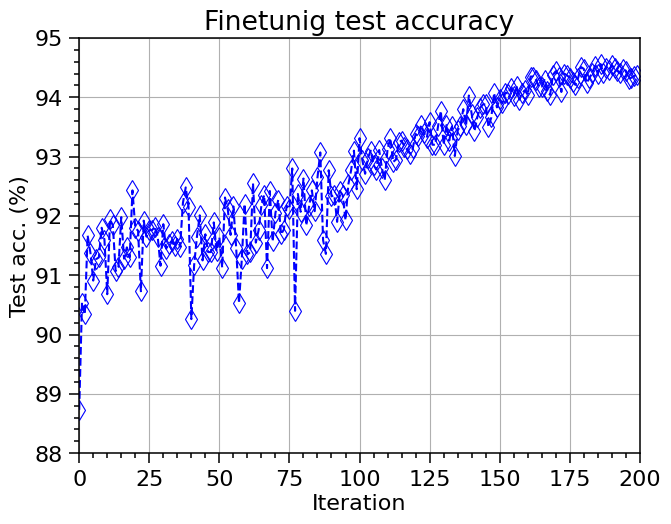

In [12]:
plt.title("Finetunig test accuracy")
plt.plot(test_accs, marker="d", linestyle="--", color="b")
plt.ylabel("Test acc. (%)")
plt.xlabel("Iteration")
plt.show()

We can also verify that the weights are clipped by looking at one random weight matrix in the network.

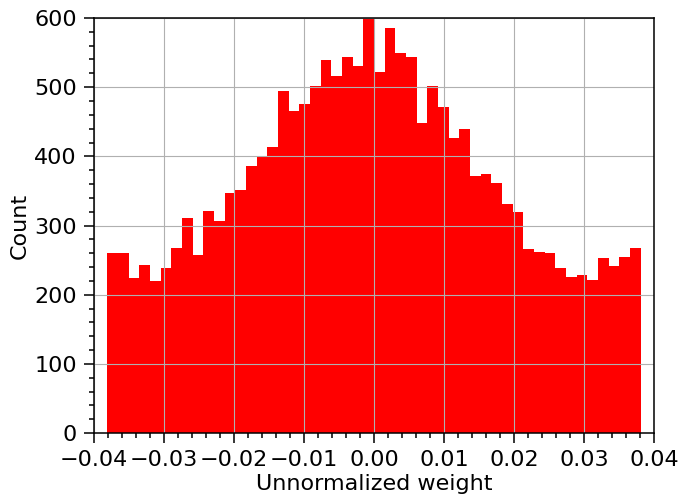

device(type='cuda')

In [13]:
w, _ = (
    analog_model
    .layer3[0]
    .conv1.analog_module.get_weights(apply_weight_scaling=True)
)
plt.hist(w.flatten().detach().numpy(), color="r", bins=50)
plt.xlabel("Unnormalized weight")
plt.ylabel("Count")
plt.show()

Finally, we would like to see how robust our model is. We first have to convert our pre-trained model to analog.
We then repeatedly call `drift_analog_weights` with a time value (in seconds). This simulates the drifting of the weights to the specified time. Note that this call also programs the weights, i.e. it simulates programming by applying specific programming noise. This noise model is defined in the `noise_model` of the RPU config.

Test loss 0.0053 test acc. 82.19%
Test loss 0.0019 test acc. 93.97%
Test loss 0.0068 test acc. 78.89%
Test loss 0.0019 test acc. 93.67%
Test loss 0.0054 test acc. 81.96%
Test loss 0.0019 test acc. 93.71%
Test loss 0.0055 test acc. 81.99%
Test loss 0.0019 test acc. 93.63%
Test loss 0.0081 test acc. 76.28%
Test loss 0.0019 test acc. 93.54%
Test loss 0.0077 test acc. 75.50%
Test loss 0.0020 test acc. 93.23%
Test loss 0.0084 test acc. 74.17%
Test loss 0.0020 test acc. 93.37%
Test loss 0.0100 test acc. 71.00%
Test loss 0.0020 test acc. 93.37%
Test loss 0.0077 test acc. 75.34%
Test loss 0.0020 test acc. 93.36%
Test loss 0.0096 test acc. 72.63%
Test loss 0.0020 test acc. 93.35%
Test loss 0.0136 test acc. 63.10%
Test loss 0.0020 test acc. 93.27%
Test loss 0.0136 test acc. 61.79%
Test loss 0.0021 test acc. 92.87%
Test loss 0.0119 test acc. 64.55%
Test loss 0.0021 test acc. 92.76%
Test loss 0.0119 test acc. 64.27%
Test loss 0.0021 test acc. 92.92%
Test loss 0.0116 test acc. 65.11%
Test loss 0.00

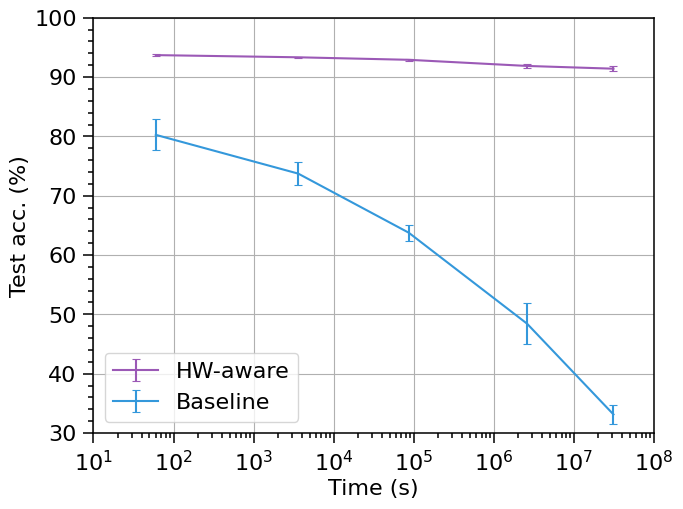

In [14]:
converted_model = convert_to_analog(model, gen_rpu_config())
# - For programming the model, we need to put it into eval() mode
converted_model = converted_model.eval()
analog_model = analog_model.eval()
# - We repeat each measurement 5 times
n_rep = 5
t_inferences = [60., 3600., 86400., 2592000., 31104000.]
drifted_test_accs = torch.zeros(size=(len(t_inferences),n_rep))
drifted_test_accs_baseline = torch.zeros(size=(len(t_inferences),n_rep))
for i,t in enumerate(t_inferences):
    for j in range(n_rep):
        converted_model.drift_analog_weights(t)
        drifted_test_accs_baseline[i,j] = test_step(converted_model, criterion, testloader)
        analog_model.drift_analog_weights(t)
        drifted_test_accs[i,j] = test_step(analog_model, criterion, testloader)
plt.errorbar(t_inferences, drifted_test_accs.mean(1), drifted_test_accs.std(1), capsize=3, label="HW-aware")
plt.errorbar(t_inferences, drifted_test_accs_baseline.mean(1), drifted_test_accs_baseline.std(1), capsize=3, label="Baseline")
plt.xlabel("Time (s)")
plt.xscale("log")
plt.ylabel("Test acc. (%)")
plt.legend()
plt.show()